<a href="https://colab.research.google.com/github/mansi104-ai/100_days_ml_code/blob/main/mobilenet_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
import tensorflow as tf


In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
DATASET_PATH = "/content/drive/MyDrive/Strawberry_images/Dataset/"

In [27]:
BATCH_SIZE = 5
IMG_SIZE = (224, 224)
SEED = 42

In [31]:
train_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,   # 80% train, 20% validation
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 251 files belonging to 2 classes.
Using 201 files for training.


In [32]:
val_ds = image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 251 files belonging to 2 classes.
Using 50 files for validation.


In [33]:
class_names = train_ds.class_names
print("Classes:", class_names)

# Improve performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Classes: ['Discolored', 'Fresh']


In [34]:
from tensorflow.keras import layers, Model
base_model = MobileNetV3Small(
    input_shape=(224, 224, 3),
    include_top=False,
    weights=None   # Train from scratch
)

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)

# Compile
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ activation[0][0]  │
│ (ZeroPadding2D)     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │        144 │ expanded_conv_de… │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 56, 56,    │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 56, 56,    │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │          0 │ re_lu[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │        136 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 8)   │          0 │ expanded_conv_sq… │
│ (ReLU)              │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 1, 1, 16)  │        144 │ expanded_conv_sq… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 16)  │          0 │ expanded_conv_sq… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 1, 1, 16)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1, 1, 16)  │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_sque… │ (None, 56, 56,    │          0 │ re_lu[0][0],      │
│ (Multiply)          │ 16)               │            │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 56, 56,    │        256 │ expanded_conv_sq

 Total params: 1,087,346 (4.15 MB)

 Trainable params: 1,075,234 (4.10 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [37]:
EPOCHS = 5
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS
)


Epoch 1/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 12s 287ms/step - accuracy: 0.9328 - loss: 0.2343 - val_accuracy: 0.4400 - val_loss: 0.6959
Epoch 2/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.8795 - loss: 0.2532 - val_accuracy: 0.4400 - val_loss: 0.6970
Epoch 3/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 274ms/step - accuracy: 0.9335 - loss: 0.1789 - val_accuracy: 0.4400 - val_loss: 0.6977
Epoch 4/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 11s 274ms/step - accuracy: 0.9482 - loss: 0.1584 - val_accuracy: 0.4400 - val_loss: 0.7005
Epoch 5/5
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - accuracy: 0.8836 - loss: 0.3391 - val_accuracy: 0.4400 - val_loss: 0.7022


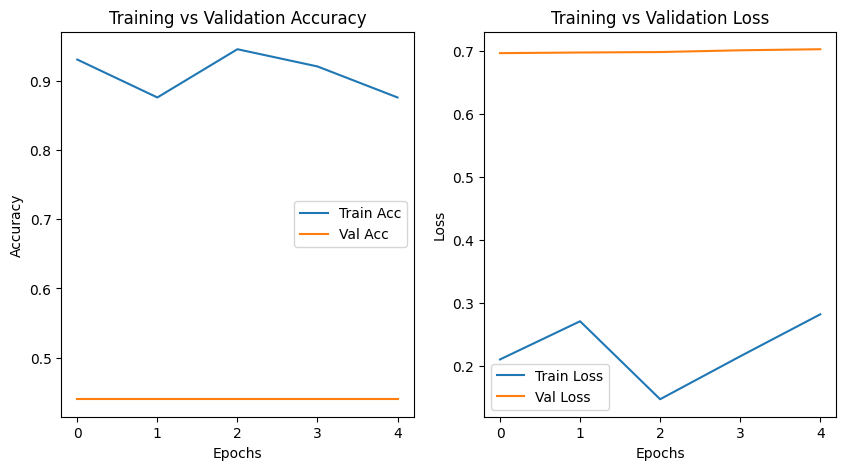

In [38]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [13]:
def create_strawberry_detector():
    """
    Create a simple strawberry detector using transfer learning with MobileNetV3
    """
    # Load base model
    base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the base model
    base_model.trainable = False

    # Add custom layers for strawberry detection
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [14]:
def detect_strawberries(image_path, threshold=0.5):
    """
    Detect strawberries in an image using color segmentation
    """
    # Read the image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Define range for red color (strawberries)
    # Strawberries may have two ranges in the HSV hue scale
    lower_red1 = np.array([0, 100, 100])
    upper_red1 = np.array([10, 255, 255])
    lower_red2 = np.array([160, 100, 100])
    upper_red2 = np.array([180, 255, 255])

    # Create masks for red detection
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

    # Combine masks
    mask = mask1 + mask2

    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours based on area to remove small noise
    min_area = 100
    strawberry_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_area]

    return img, strawberry_contours


In [15]:
def annotate_strawberries(img, contours):
    """
    Annotate detected strawberries on the image
    """
    # Create a copy of the image for annotation
    annotated_img = img.copy()

    # Draw contours and numbering
    for i, cnt in enumerate(contours):
        # Draw the contour
        cv2.drawContours(annotated_img, [cnt], -1, (0, 255, 0), 2)

        # Calculate centroid of the contour
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0

        # Draw the strawberry number
        cv2.putText(annotated_img, str(i+1), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 255, 255), 2, cv2.LINE_AA)

    # Add annotation info
    text = f"Total strawberries detected: {len(contours)}"
    cv2.putText(annotated_img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (255, 255, 255), 2, cv2.LINE_AA)

    return annotated_img


In [16]:
def annotate_strawberries(img, contours):
    """
    Annotate detected strawberries on the image
    """
    # Create a copy of the image for annotation
    annotated_img = img.copy()

    # Draw contours and numbering
    for i, cnt in enumerate(contours):
        # Draw the contour
        cv2.drawContours(annotated_img, [cnt], -1, (0, 255, 0), 2)

        # Calculate centroid of the contour
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0

        # Draw the strawberry number
        cv2.putText(annotated_img, str(i+1), (cx, cy), cv2.FONT_HERSHEY_SIMPLEX,
                    0.5, (255, 255, 255), 2, cv2.LINE_AA)

    # Add annotation info
    text = f"Total strawberries detected: {len(contours)}"
    cv2.putText(annotated_img, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX,
                0.7, (255, 255, 255), 2, cv2.LINE_AA)

    return annotated_img

def main(image_path):
    """
    Main function to detect and annotate strawberries
    """
    # Detect strawberries
    img, strawberry_contours = detect_strawberries(image_path)

    # Annotate the image
    annotated_img = annotate_strawberries(img, strawberry_contours)

    # Display results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.imshow(img)
    ax1.set_title('Original Image')
    ax1.axis('off')

    ax2.imshow(annotated_img)
    ax2.set_title(f'Annotated Image: {len(strawberry_contours)} strawberries')
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

    return annotated_img

In [17]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from PIL import Image
import matplotlib.pyplot as plt

# Path to your image
annotated_image = '/content/drive/MyDrive/Strawberry_images/image_1.jpg'

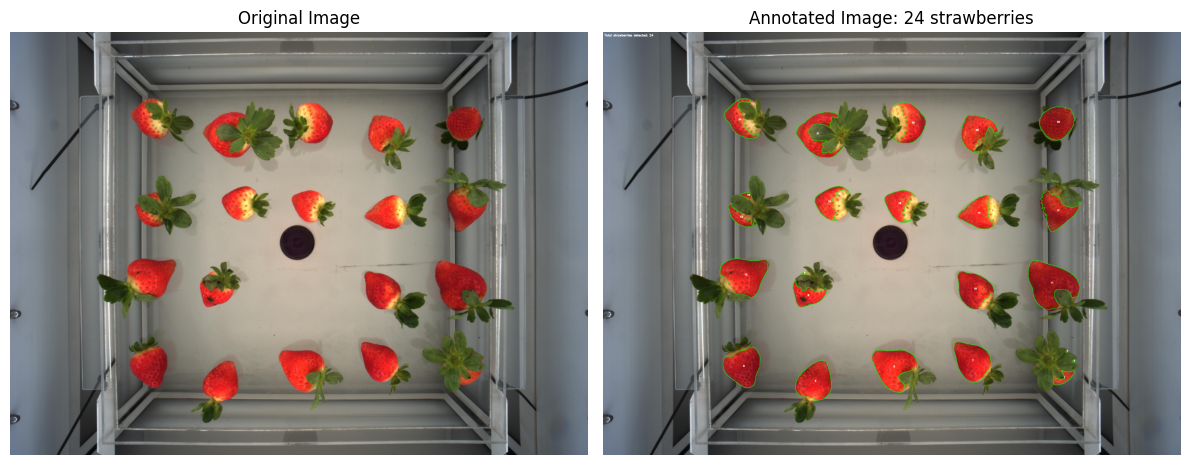

In [20]:
# Usage:
annotated_image = main(annotated_image)

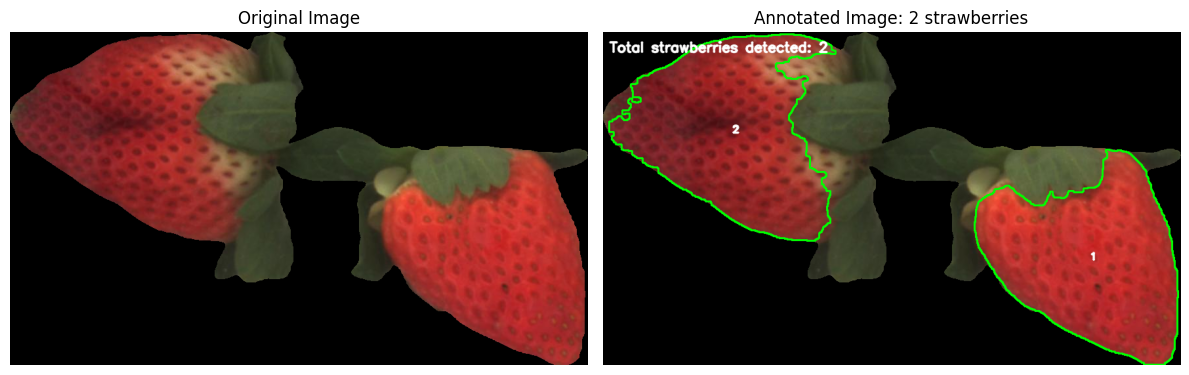

In [21]:
annotated_image = main('/content/drive/MyDrive/Strawberry_images/image_2.png')